## Feature Importance Analysis: Polymer-aware vs RDKit

This notebook analyzes and compares feature importance from Random Forest models
trained with RDKit-only descriptors and with polymer-augmented features. The goal
is to assess whether polymer-aware features contribute meaningful, physically
interpretable signals to Tg prediction.

In [2]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt

In [3]:
rf_base = joblib.load("../models/baseline_random_forest_model.pkl")
rf_poly = joblib.load("../models/baseline_random_forest_model_polymer.pkl")

In [4]:
rdkit_features = pd.read_csv(
    "../data/processed/selected_baseline_features.csv"
).squeeze()

In [5]:
polymer_features = pd.read_csv(
    "../data/processed/selected_baseline_polymer_features.csv"
).squeeze()

In [6]:
imp_base = pd.Series(
    rf_base.feature_importances_,
    index=rdkit_features,
    name="importance"
).sort_values(ascending=False)

imp_poly = pd.Series(
    rf_poly.feature_importances_,
    index=polymer_features,
    name="importance"
).sort_values(ascending=False)

In [7]:
imp_poly.head(20)

0
rotatable_bond_frac    0.598519
BertzCT                0.073115
FractionCSP3           0.039764
VSA_EState4            0.015267
SlogP_VSA1             0.015012
SMR_VSA7               0.011974
fr_aniline             0.010034
MaxAbsEStateIndex      0.009021
BalabanJ               0.008300
frac_N                 0.007311
VSA_EState1            0.007156
fr_NH1                 0.006733
SPS                    0.006587
VSA_EState8            0.006184
VSA_EState3            0.005703
MinEStateIndex         0.005686
fr_bicyclic            0.005548
aromatic_atom_frac     0.005341
VSA_EState2            0.005299
MinAbsEStateIndex      0.005250
Name: importance, dtype: float64

In [8]:
polymer_feature_mask = imp_poly.index.str.contains(
    "frac_|aromatic_|rotatable_|heavy_atom"
)

imp_polymer_only = imp_poly[polymer_feature_mask]
imp_polymer_only.head(15)

0
rotatable_bond_frac    0.598519
frac_N                 0.007311
aromatic_atom_frac     0.005341
frac_C                 0.004671
frac_O                 0.003297
frac_S                 0.000990
Name: importance, dtype: float64

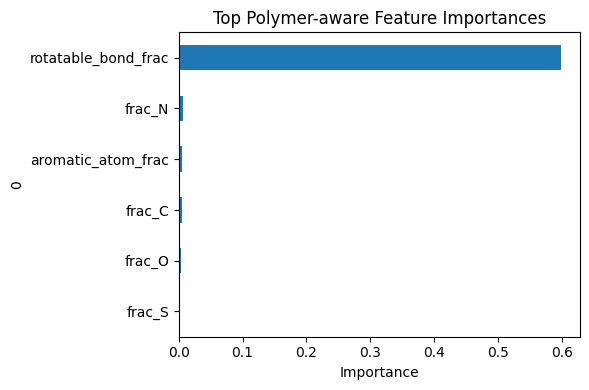

In [9]:
top_poly = imp_polymer_only.head(10)

plt.figure(figsize=(6, 4))
top_poly.sort_values().plot(kind="barh")
plt.title("Top Polymer-aware Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [10]:
print("Top RDKit features:")
print(imp_base.head(10))

print("\nTop Polymer-aware features:")
print(imp_poly.head(10))

Top RDKit features:
0
FractionCSP3         0.460798
NumAliphaticRings    0.067724
NumHeterocycles      0.042262
fr_bicyclic          0.040382
SMR_VSA7             0.031915
NumRotatableBonds    0.027016
BertzCT              0.021175
VSA_EState4          0.019450
MaxAbsEStateIndex    0.014436
SlogP_VSA1           0.012479
Name: importance, dtype: float64

Top Polymer-aware features:
0
rotatable_bond_frac    0.598519
BertzCT                0.073115
FractionCSP3           0.039764
VSA_EState4            0.015267
SlogP_VSA1             0.015012
SMR_VSA7               0.011974
fr_aniline             0.010034
MaxAbsEStateIndex      0.009021
BalabanJ               0.008300
frac_N                 0.007311
Name: importance, dtype: float64


### Descriptor Grouping by Physical Meaning

| Category | Representative Descriptors | Physical Interpretation |
|--------|----------------------------|-------------------------|
| Chain Flexibility | rotatable_bond_frac, NumRotatableBonds | Backbone mobility and segmental motion |
| Chain Rigidity | aromatic_ring_count, aromatic_atom_frac, FractionCSP3 | Backbone stiffness and conformational constraints |
| Molecular Size / Complexity | BertzCT, heavy_atom_count, fr_bicyclic | Structural complexity and steric effects |
| Polarity / Intermolecular Interaction | frac_N, frac_O, TPSA, VSA_EState4 | Dipole interactions and secondary bonding |
| Topology / Shape | SMR_VSA7, slogP_VSA1 | Molecular shape and spatial distribution of functionality |


## Feature Importance Interpretation

Feature importance analysis reveals a clear distinction between generic RDKit
descriptors and polymer-aware features.

For the RDKit-only baseline, the most influential features include descriptors
related to molecular rigidity and topology, such as FractionCSP3, ring counts,
BertzCT, and VSA/EState-based features. These descriptors broadly capture molecular
size, branching, and aromaticity, providing a strong generic representation for
Tg prediction.

In the polymer-augmented model, the fraction of rotatable bonds
(`rotatable_bond_frac`) emerges as the dominant polymer-aware feature, accounting
for a substantial portion of the total feature importance. This result is
physically meaningful, as the glass transition temperature is strongly governed
by polymer chain mobility and segmental flexibility. A higher fraction of
rotatable bonds corresponds to increased backbone flexibility and enhanced
segmental motion, which is known to lower Tg.

Other polymer-aware features, such as elemental composition fractions and
aromaticity-related metrics, exhibit comparatively lower importance. This likely
reflects redundancy with existing RDKit descriptors that already encode similar
chemical information (e.g., aromaticity, ring structure, and bonding patterns).
Rather than indicating irrelevance, this suggests that the model preferentially
selects a small number of highly informative proxies when multiple correlated
descriptors are available.

Overall, the feature importance results indicate that polymer-aware descriptors
provide physically interpretable signals that complement generic RDKit features.
In particular, the prominence of `rotatable_bond_frac` highlights chain
flexibility as a key driver of Tg within this dataset, aligning well with
established polymer physics principles.

## Interpretation by Physical Category

When grouped by physical meaning, the feature importance results indicate that
chain flexibility and rigidity-related descriptors dominate Tg prediction. In
particular, rotatable bond fraction emerges as the most influential polymer-aware
descriptor, highlighting the central role of segmental mobility in governing Tg.

Descriptors associated with molecular size and complexity (e.g., BertzCT) also
contribute meaningfully, suggesting that steric constraints and backbone
architecture affect glass transition behavior. Polarity-related features exhibit
lower but non-negligible importance, consistent with secondary intermolecular
interactions modulating Tg without being the primary driver.
